In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize

import scipy
import pandas as pd

In [66]:
# V vector looks like   (x, y, a, s, w) <pos_x, pos_y, angle, signed_speed, omega>
# V' vector looks like  (s*cos(a), s*sin(a), w, phi, psi, 1)
# V'' looks like        ()

V0 = np.array([0, 0, -2, 5, 1])   # initial position
F = np.array([0.25, -0.1])                # forcing terms 
dt  =  0.1

def V_prime(V, F):
    A, S, W = V[2], V[3], V[4]
    PHI, PSI = F[0], F[1]
    X_prime = S * np.cos(A)
    Y_prime = S * np.sin(A)
    A_prime = W
    S_prime = PHI
    W_prime = PSI
    return np.stack([X_prime, Y_prime, A_prime, S_prime, W_prime])


def V_derivatives(V, delta):
    X, Y, A, S, W, _0, _1 = V[:,0], V[:,1], V[:,2], V[:,3], V[:,4], 0*V[:,0], 0*V[:,0]+1
    a1 = np.stack([X, Y, A, S, W], axis=1)
    a2 = np.stack([S*np.cos(A), S*np.sin(A), W, _0, _0], axis=1)
    b2 = np.stack([_0, _0, _0, _1, _0], axis=1)
    c2 = np.stack([_0, _0, _0, _0, _1], axis=1)
    b3 = np.stack([np.cos(A), np.sin(A), _0, _0, _0], axis=1)
    c3 = np.stack([-S*np.sin(A), S*np.cos(A), _1, _0, _0], axis=1)
    a = a1 + delta*a2
    b = delta*b2 + (0.5*delta*delta)*b3
    c = delta*c2 + (0.5*delta*delta)*c3
    return a, b, c


def integrate(V0, F, ts):
    VS = np.zeros((len(ts), 5))
    VS[0,:] = V0

    for i in range(len(ts)-1):
        dt = ts[i+1] - ts[i]
        VS[i+1,:] = VS[i] + dt * V_prime(VS[i], F)

    return VS

def integrate2(V0, F, ts):
    VS = np.zeros((len(ts), 5))
    VS[0,:] = V0

    for i in range(len(ts)-1):
        dt = ts[i+1] - ts[i]
        a, b, c = (_[0,:] for _ in V_derivatives(VS[i][np.newaxis,:], dt))
        VS[i+1,:] = a + F[0] * b + F[1] * c

    return VS

t0 = 0
t1 = 20
dt = 0.25

TS = np.linspace(t0, t1, int((t1-t0)/dt))
TS_DENSE = np.linspace(t0, t1, 100*int((t1-t0)/dt))

VS = integrate(V0, F, TS)
VS_acc = integrate2(V0, F, TS)
VSTRUE = integrate2(V0, F, TS_DENSE)


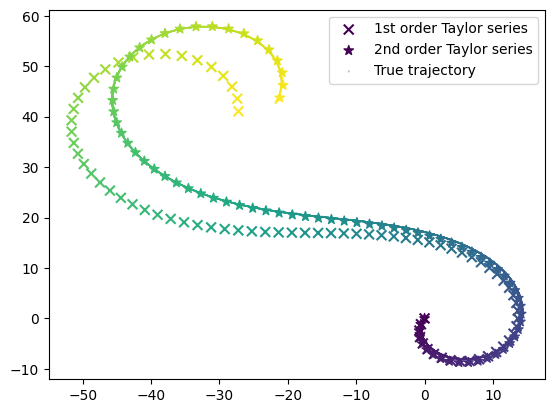

In [71]:
plt.scatter(VS[:,0], VS[:,1], marker='x', c=VS[:,3], cmap='viridis', s=50)
plt.scatter(VS_acc[:,0], VS_acc[:,1], marker='*', c=VS_acc[:,3], cmap='viridis', s=50)
plt.scatter(VSTRUE[:,0], VSTRUE[:,1], marker='.', c=VSTRUE[:,3], cmap='viridis', s=0.1)
plt.legend(['1st order Taylor series', '2nd order Taylor series', 'True trajectory'])
plt.show()

# def computeDistances(VSTRUE, VS):


    # tmax = VSTRUE[-1,5]
    # tmin = VSTRUE[0,5]
    # floatIndices = (VS[:,5] - tmin) / (tmax - tmin) * (VSTRUE.shape[0]-1)

    # floorIndices = np.floor(floatIndices).astype(int)
    # ceilIndices = np.floor(floatIndices).astype(int)
    # remainderIndices = (floatIndices - floorIndices)[:,np.newaxis]

    # RESHAPED_TRUE = VSTRUE[floorIndices,:] * (1 - remainderIndices) + VSTRUE[ceilIndices,:] * remainderIndices
    # return np.sum((RESHAPED_TRUE - VS) ** 2, axis=1)

def sampleTrue(nsamples):
    floatIndices = np.linspace(0, VSTRUE.shape[0]-1, nsamples)

    floorIndices = np.floor(floatIndices).astype(int)
    ceilIndices = np.floor(floatIndices).astype(int)
    remainderIndices = (floatIndices - floorIndices)[:,np.newaxis]

    return VSTRUE[floorIndices,:] * (1 - remainderIndices) + VSTRUE[ceilIndices,:] * remainderIndices


# plt.plot(computeDistances(VSTRUE, VS))
# plt.plot(computeDistances(VSTRUE, VS_acc))

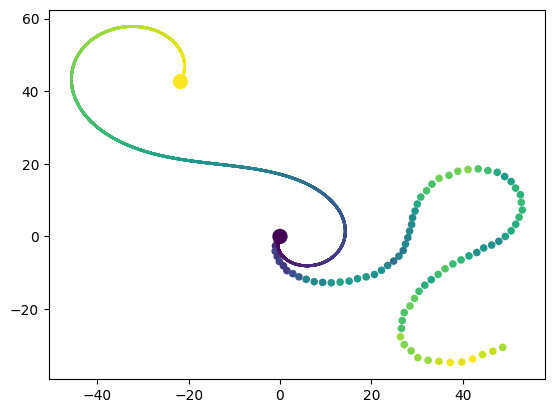

In [78]:
np.random.seed(254)


def integratePath2(V0, F, ts):
    VS = np.zeros((len(ts), 5))
    VS[0,:] = V0

    for i in range(len(ts)-1):
        dt = ts[i+1] - ts[i]
        a, b, c = (_[0,:] for _ in V_derivatives(VS[i][np.newaxis,:], dt))
        VS[i+1,:] = a + F[i,0] * b + F[i,1] * c

    return VS




V0 = VSTRUE[0,:]        # start
V1 = VSTRUE[-1,:]       # target
T0 = TS[0]              # initial time
T1 = TS[-1]             # end time

n = TS.shape[0]         # number of timesteps

F = np.random.normal(0, 1, size=(n, 2))    # predicted forcing terms

VS = integratePath2(V0, F, TS)

plt.scatter(VS[:,0], VS[:,1], c=VS[:,3], cmap='viridis', s=20)
plt.scatter(VSTRUE[:,0], VSTRUE[:,1], c=VSTRUE[:,3], cmap='viridis', s=1)
plt.scatter(VSTRUE[[0,-1],0], VSTRUE[[0,-1],1], marker='o', c=VSTRUE[[0,-1],3], cmap='viridis', s=100)

plt.show()


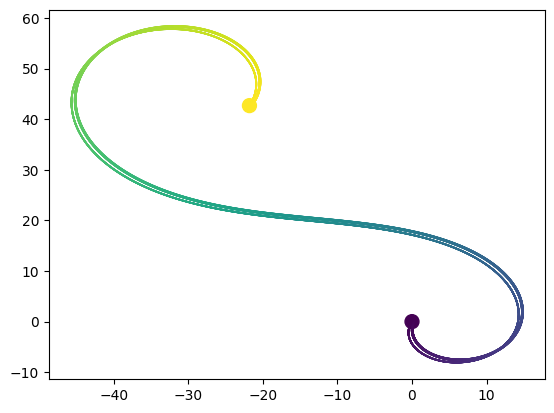

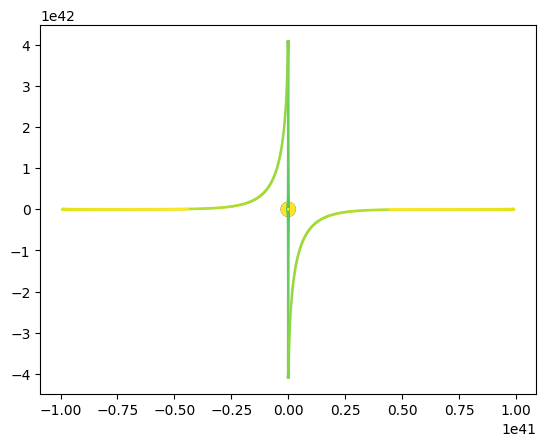

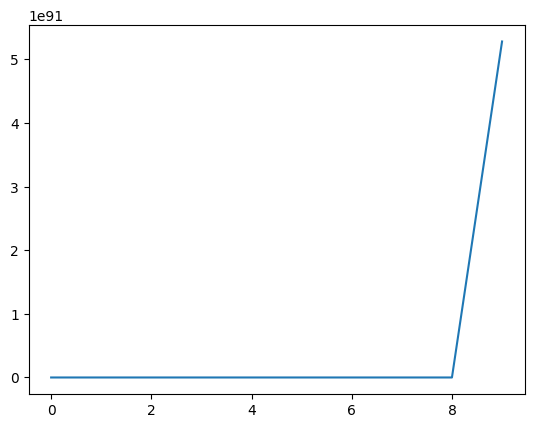

In [ ]:
V0 = np.array([0, 0, -2, 5, 1])   # initial position
V1 = VSTRUE[-1,:]
FixedPoints = np.stack([V0, V1])



t0 = TS[0]
t1 = TS[-1]
dt = 0.005
ndivs = int((t1-t0)/dt)
ratios = np.linspace(0, 1, ndivs)[:,np.newaxis]
RasterPath = (1-ratios) * V0 + ratios * V1

RasterPath = sampleTrue(ndivs) + 0.5
noise = np.random.normal(size=RasterPath.shape)
# RasterPath += 0.001 * noise


plt.scatter(FixedPoints[:,0], FixedPoints[:,1], marker='o', c=FixedPoints[:,3], cmap='viridis', s=100)
plt.scatter(VSTRUE[:,0], VSTRUE[:,1], c=VSTRUE[:,3], cmap='viridis', s=0.1)
plt.scatter(RasterPath[:,0], RasterPath[:,1], c=RasterPath[:,3], cmap='viridis', s=1)
plt.show()


proj = lambda a, b: (np.sum(a * b, axis=1) / (np.sum(b * b, axis=1) + 1e-6))[:, np.newaxis] * b


def computeResidules(path0, path1):
    a, b, c = V_derivatives(path0, dt*path0[:,np.newaxis])     # previous point
    Q = path1 - a                                               # point of interest
    proj_PHI = proj(Q, b)                                       # change explained by linear acceleration
    proj_PSI = proj(Q, c)                                       # change explained by angular acceleration
    R_perp = Q - proj_PHI - proj_PSI                            # perpenducilar distance from manifold
    return R_perp

def relax(path, lr=0.9):                        # path relaxes to valid solution
    # gradients = np.zeros_like(path)

    # triangle0 = np.linspace(1, 0, path.shape[0])[:,np.newaxis]
    # triangle1 = np.linspace(0, 1, path.shape[0])[:,np.newaxis]
    
    # gap = 1
    # # for gap in range(1,2):
    # gradients[gap:,:] += computeResidules(path[:-gap,:], path[gap:,:]) * triangle0[:-gap] ** 1
    # gradients[:-gap,:] += computeResidules(path[gap:,:], path[:-gap,:]) * triangle1[:-gap] ** 1


    gradientsMask = np.ones_like(path)
    gradientsMask[0,:] = 0  # cant move start point
    gradientsMask[-1,:] = [0, 0, 1, 1, 1]  # cant move end point
    # gradientsMask[1:,5] = 1


    # path = path - lr * gradients * gradientsMask, np.sum(gradients ** 2)

    for i in range(path.shape[0]-1):
        f = 1 - i / (path.shape[0]-1)
        f=1
        path[i+1,:] = path[i+1,:] - 0.95 * f * computeResidules(path[i,:][np.newaxis,:], path[i+1,:][np.newaxis,:])[0,:] * gradientsMask[i+1,:]

        i = i + 1
        f = 1 - i / (path.shape[0]-1)
        f=1
        path[-i-1,:] = path[-i-1,:] - 0.95 * f * computeResidules(path[-i,:][np.newaxis,:], path[-i-1,:][np.newaxis,:])[0,:] * gradientsMask[-i-1,:]

    # for i in range(1, path.shape[0]):
    #     f = 1 - i / (path.shape[0]-1)
    #     f=1
    #     path[-i-1,:] = path[-i-1,:] - 0.95 * f * computeResidules(path[-i,:][np.newaxis,:], path[-i-1,:][np.newaxis,:])[0,:] * gradientsMask[-i-1,:]

    return path, np.sum(computeResidules(path[:-1,:], path[1:,:])**2)

# def grad(path):
#     path = path.reshape(-1, 6)
#     gradients = np.zeros_like(path)

#     triangle0 = np.linspace(1, 0, path.shape[0])[:,np.newaxis]
#     triangle1 = np.linspace(0, 1, path.shape[0])[:,np.newaxis]

#     gradients[1:,:] += computeResidules(path[:-1,:], path[1:,:]) * triangle0[:-1] ** 1
#     gradients[:-1,:] += computeResidules(path[1:,:], path[:-1,:]) * triangle1[:-1] ** 1

#     gradientsMask = np.ones_like(path)
#     gradientsMask[0,:] = 0  # cant move start point
#     gradientsMask[-1,:] = [0, 0, 1, 1, 1, 1]  # cant move end point
#     gradientsMask[1:,5] = 1

#     return (gradients * gradientsMask).flatten()

# def loss(path):
#     return np.sum(grad(path)**2)
# # SLSQP
# x0 = RasterPath.flatten()
# res = minimize(loss, x0, method='Powell', jac=grad)
# print(res)
# res = res.x.reshape(-1, 6)

losses = []
for i in range(10):
    RasterPath, loss = relax(RasterPath, lr=1e-3)
    losses.append(loss)



plt.scatter(FixedPoints[:,0], FixedPoints[:,1], marker='o', c=FixedPoints[:,3], cmap='viridis', s=100)
# plt.scatter(res[:,0], res[:,1], marker='o', c=res[:,3], cmap='cool', s=1)
plt.scatter(VSTRUE[:,0], VSTRUE[:,1], c=VSTRUE[:,3], cmap='viridis', s=0.1)
plt.scatter(RasterPath[:,0], RasterPath[:,1], c=RasterPath[:,3], cmap='viridis', s=1)
plt.show()

plt.plot(losses)
plt.show()
